# ECG Personal Info Lock

### Import Neccsary libraries 

In [2]:

import os
import numpy as geek
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import pickle

### Read Data

In [3]:

def read_ecg_data(file_path):
    df = pd.read_csv(file_path, skiprows=2)
    ecgX = df.iloc[:, 0].values
    ecgY = df.iloc[:, 1].values
    return ecgX, ecgY
    

### Band Pass filter

In [4]:

def butter_Banpass_filter(data, Low_Cutoff, High_Cutoff, SamplingRate, order):
    nyq = 0.5 * SamplingRate
    low = Low_Cutoff / nyq
    high = High_Cutoff / nyq
    b, a = butter(order, [low, high], btype='band', analog=False, fs=None)
    Filtered_Data = filtfilt(b, a, data)
    return Filtered_Data



### Feature Extraction

In [5]:

def detect_q_s_points(signal, r_peaks):
    q_points = []
    s_points = []
    for r_peak in r_peaks:
        n = len(signal)

        for i in range(r_peak - 1, 0, -1):
            if signal[i] < signal[i - 1]:
                q_points.append(i)
                break

        for i in range(r_peak + 1, n - 1):
            if signal[i] < signal[i + 1]:
                s_points.append(i)
                break

    return q_points, s_points


def detect_t_points(signal, s_peaks):
    t_points = []
    for s_peak in s_peaks:
        n = len(signal)

        for i in range(s_peak + 1, n - 1):
            if signal[i] > signal[i + 1]:
                t_points.append(i)
                break

    return t_points




### Apply Preprocessing and fetures Extraction

In [10]:

def process_ecg_file(file_path):
    ecgX, ecgY = read_ecg_data(file_path)
    # band pass filter
    Filtered_signal = butter_Banpass_filter(ecgY, Low_Cutoff=1, High_Cutoff=40, SamplingRate=250, order=2)

    arr_x = geek.array(ecgX)
    arr_y = geek.array(Filtered_signal)
    # differntiation
    # x = geek.diff(arr_x)
    y = geek.diff(arr_y)
    dy = np.zeros(59999)
    dy[0:len(dy) - 1] = y

    plt.figure(figsize=(8, 6))
    plt.plot(ecgX, ecgY)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude(v)')
    plt.title('Original ECG Signal')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(0, len(Filtered_signal)), Filtered_signal)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude(v)')
    plt.title('Filtered ECG Signal')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(0, len(dy)), dy)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude(v)')
    plt.title('First Derivative')
    plt.show()
# squaring
    result = [dy[i] ** 2 for i in range(len(dy))]
# moving window integration
    win_size = round(0.05 * 250)
    sum_val = 0
    for j in range(win_size):
        sum_val += result[j] / win_size
        result[j] = sum_val

    for index in range(win_size, len(result)):
        sum_val += result[index] / win_size
        sum_val -= result[index - win_size] / win_size
        result[index] = sum_val
# center and smoothing
    result = butter_Banpass_filter(result, Low_Cutoff=1, High_Cutoff=40, SamplingRate=250, order=2)

    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(0, len(result)), result)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude(v)')
    plt.title('Squared First Derivative with Moving Average')
    plt.show()
    
# threshold (dynamic)
    r_points, _ = find_peaks(result, height=np.mean(result) + 0.5*np.std(result), distance=100)

    q_points, s_points = detect_q_s_points(result, r_points)
    t_points = detect_t_points(result, s_points)

    print(len(r_points), len(q_points), len(s_points), len(t_points))

    R_peaks = result[r_points]
    S_peaks = result[s_points]
    Q_peaks = result[q_points]
    T_peaks = result[t_points]

    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(0, len(result)), result)
    plt.plot(r_points, result[r_points], 'x', color='red', label='R Peaks')
    plt.plot(q_points, result[q_points], 'x', color='green', label='Q Valleys')
    plt.plot(s_points, result[s_points], 'x', color='blue', label='S Valleys')
    plt.plot(t_points, result[t_points], 'x', color='yellow', label='T Peaks')
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude(v)')
    plt.legend()
    plt.title('R Peaks, Q valleys and S Valleys')
    plt.show()

    return R_peaks, S_peaks, Q_peaks, T_peaks


### Main and training models

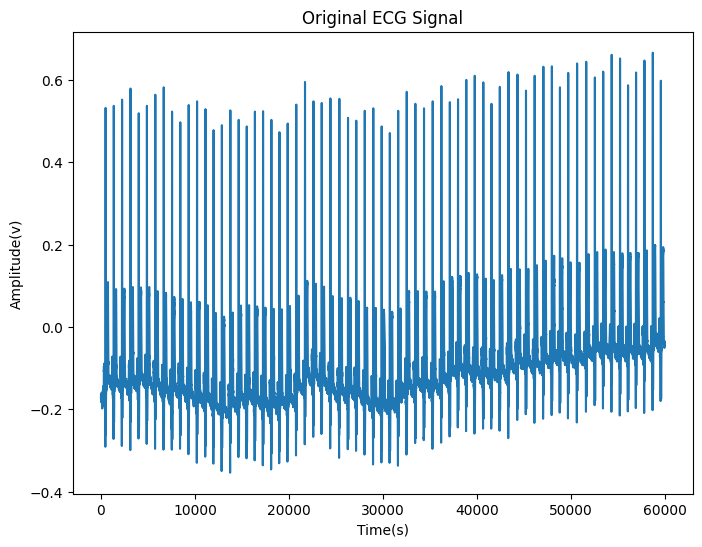

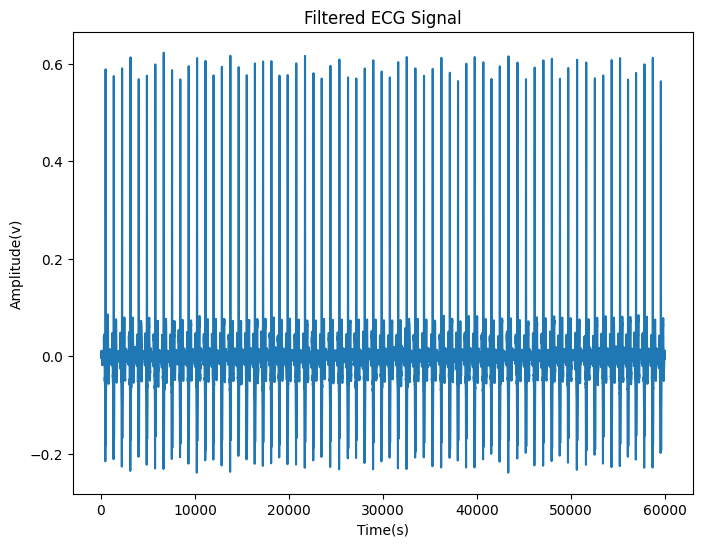

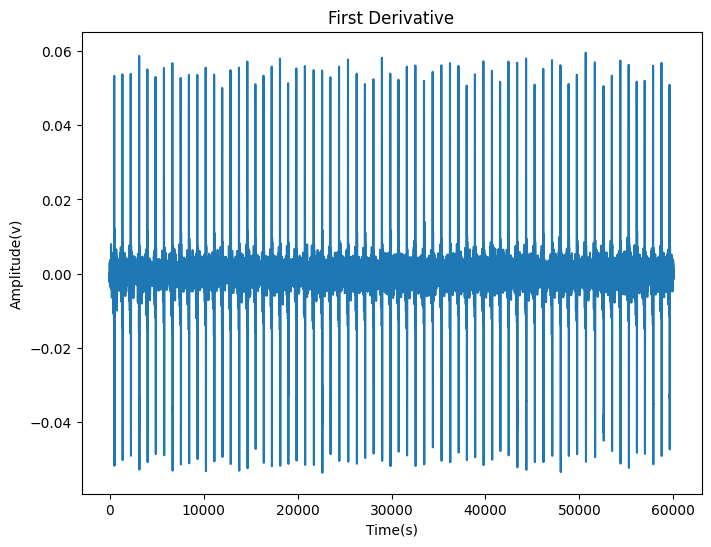

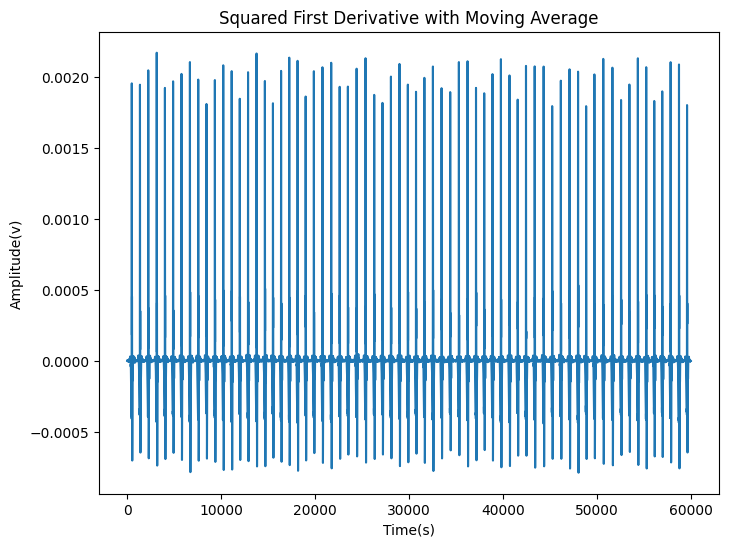

67 67 67 67


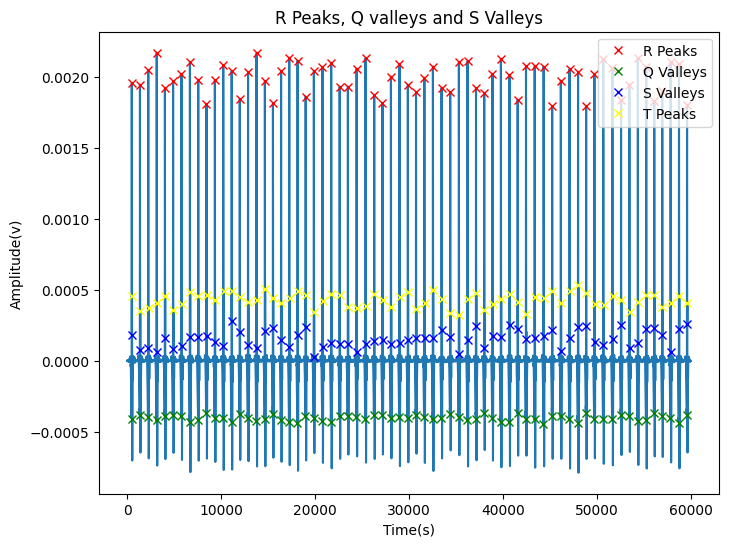

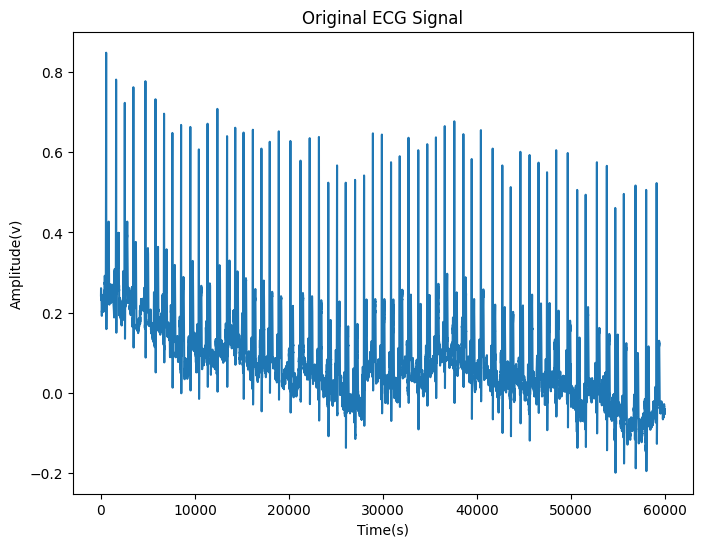

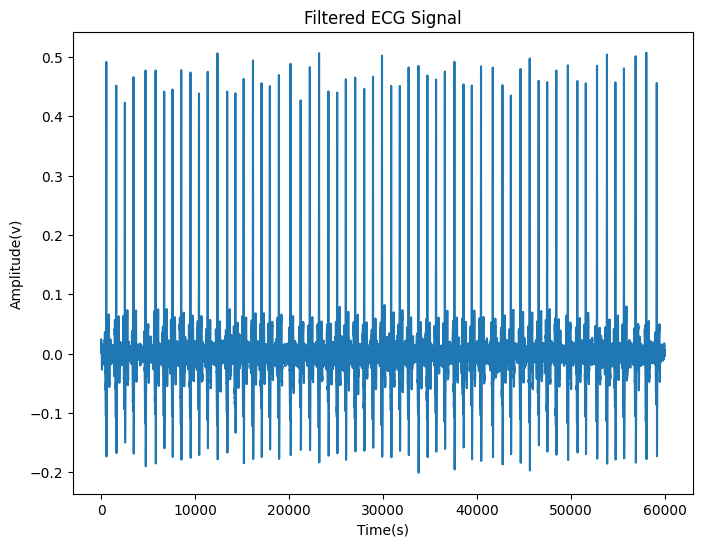

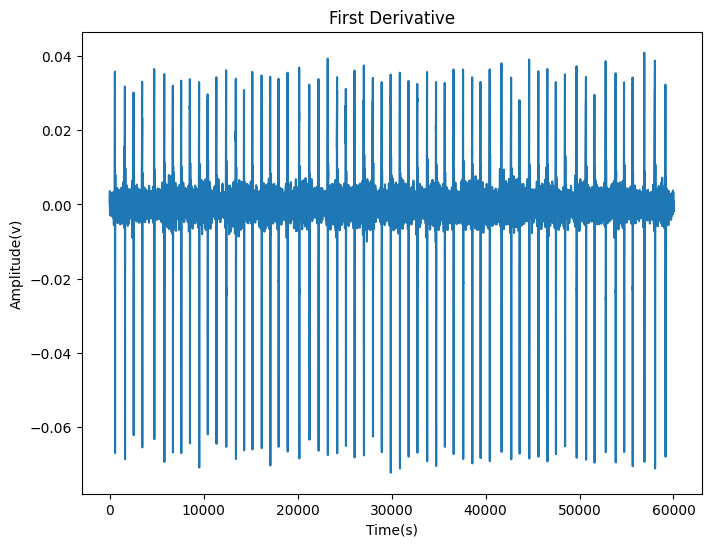

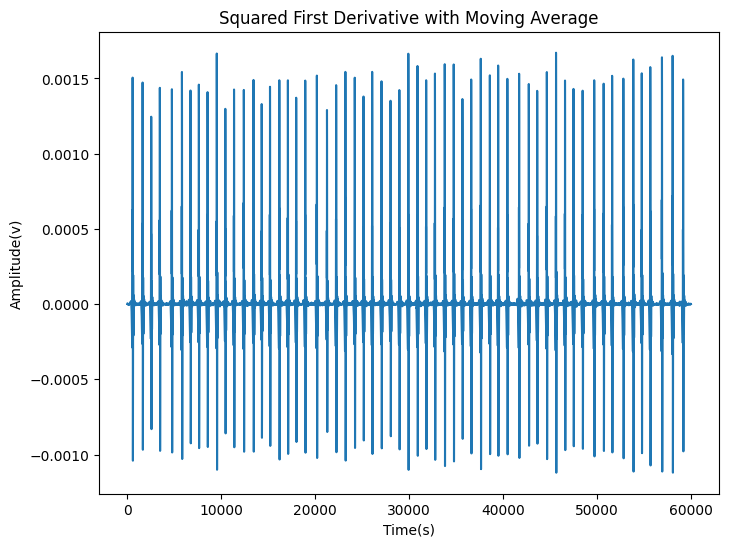

60 60 60 60


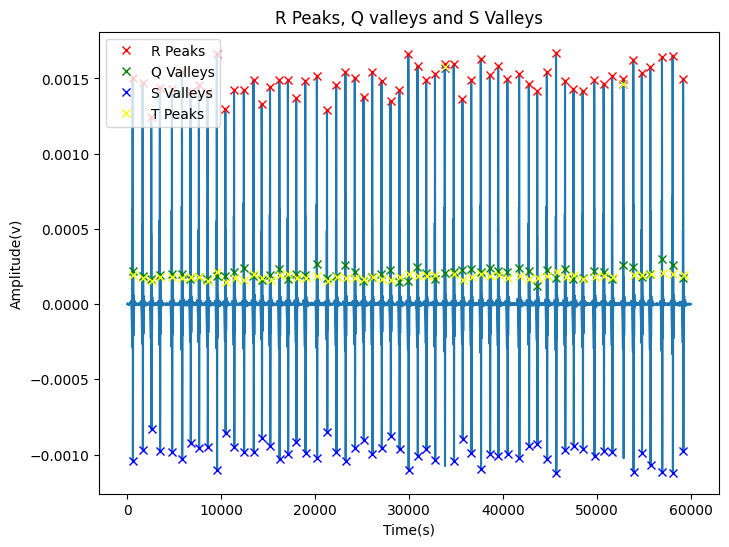

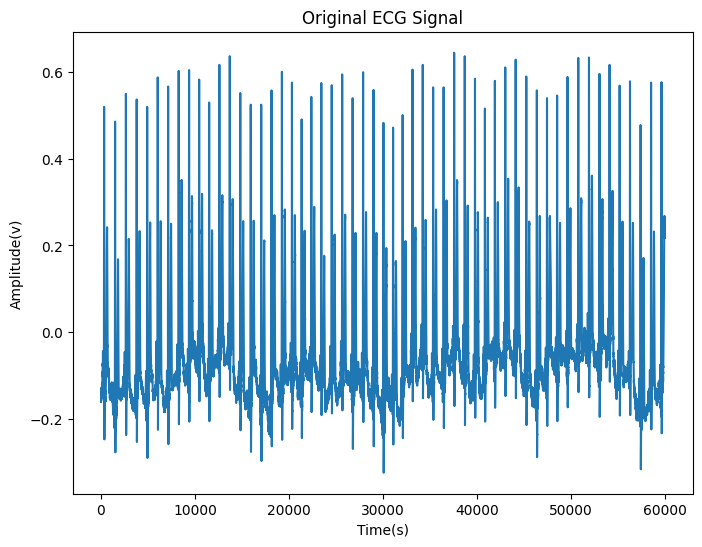

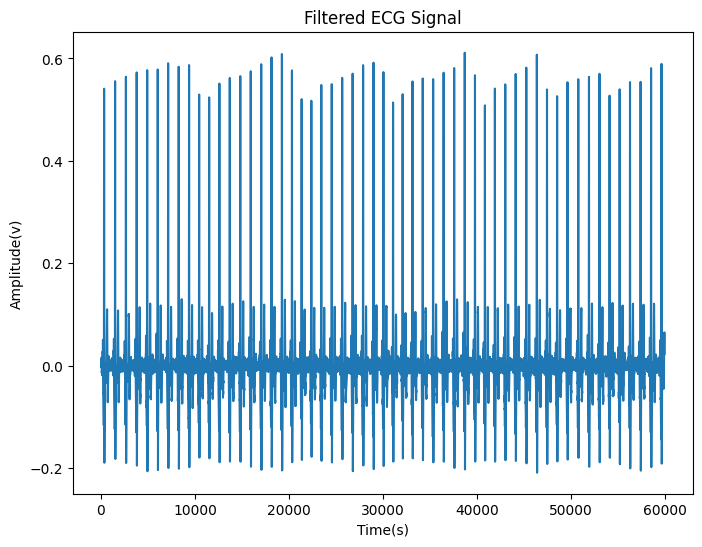

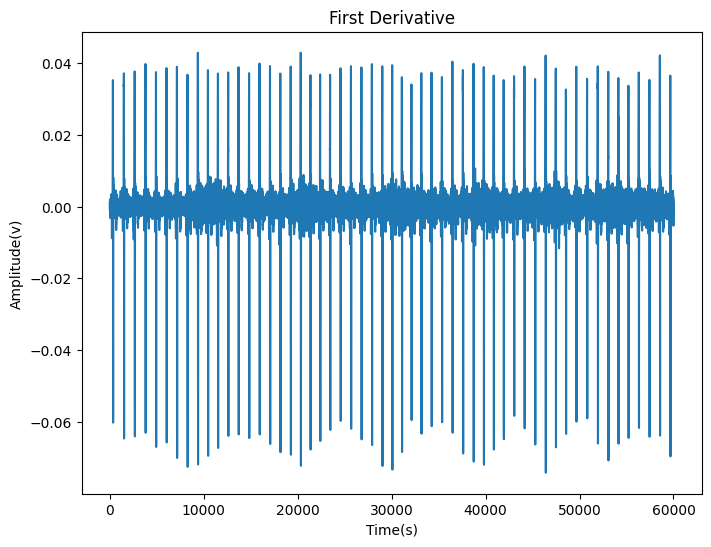

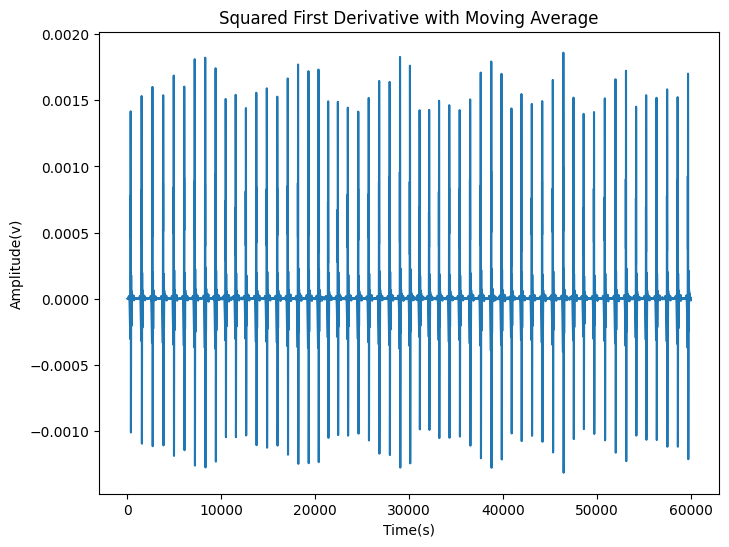

55 55 55 55


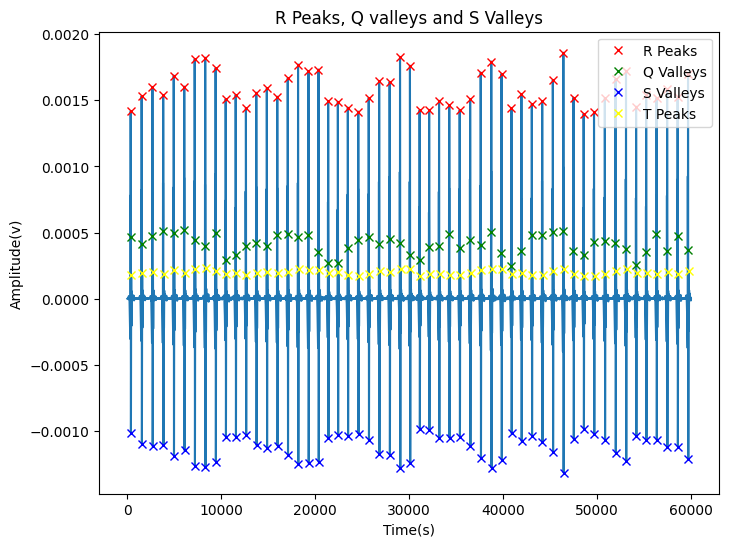

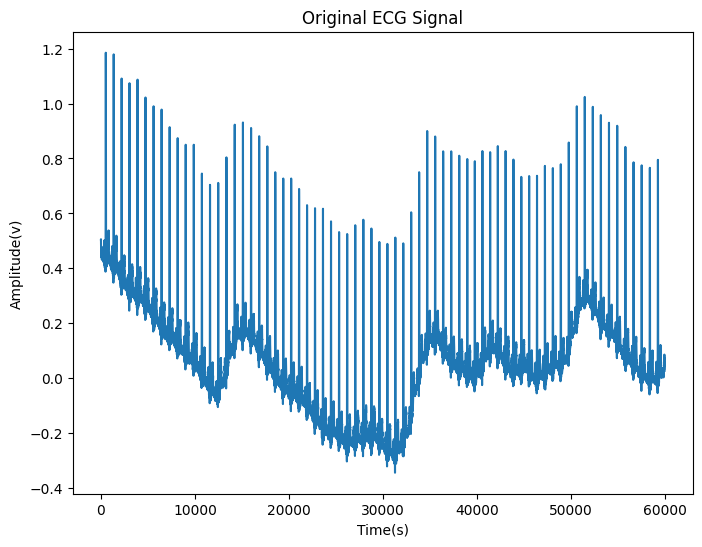

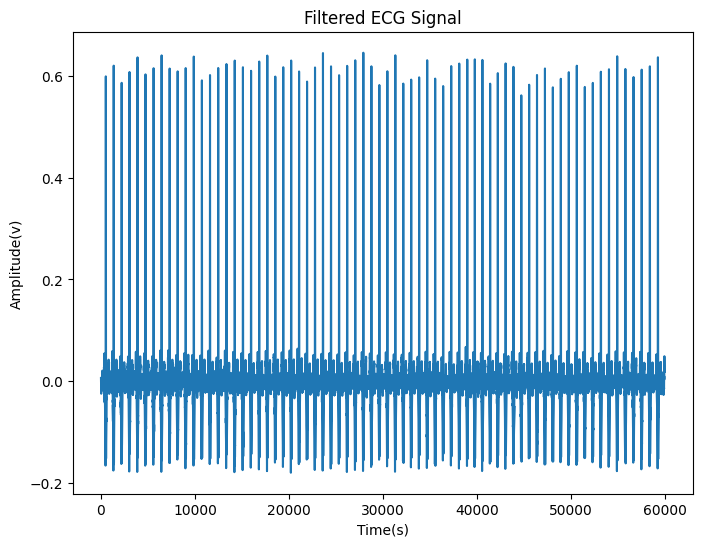

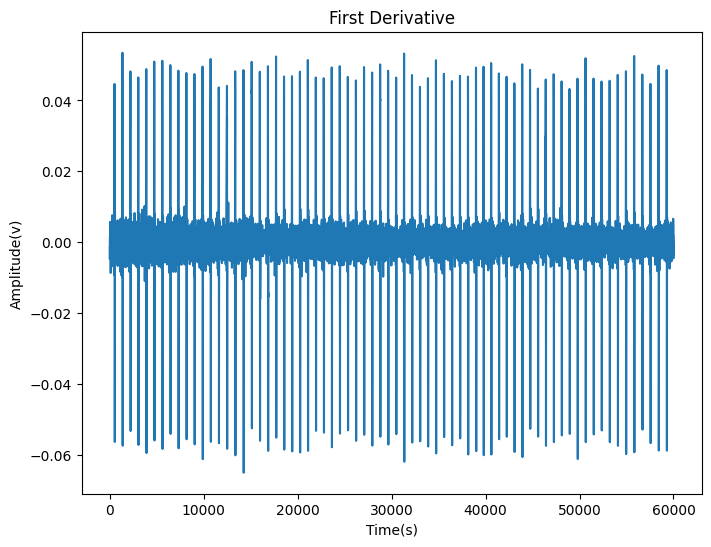

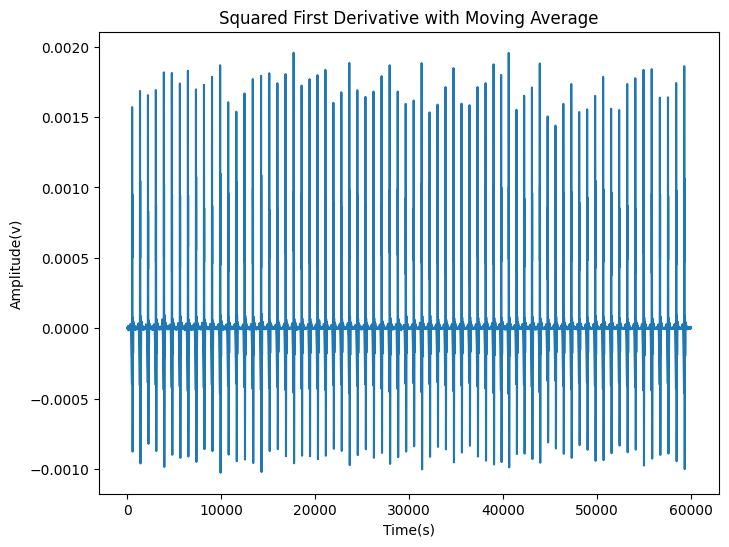

70 70 70 70


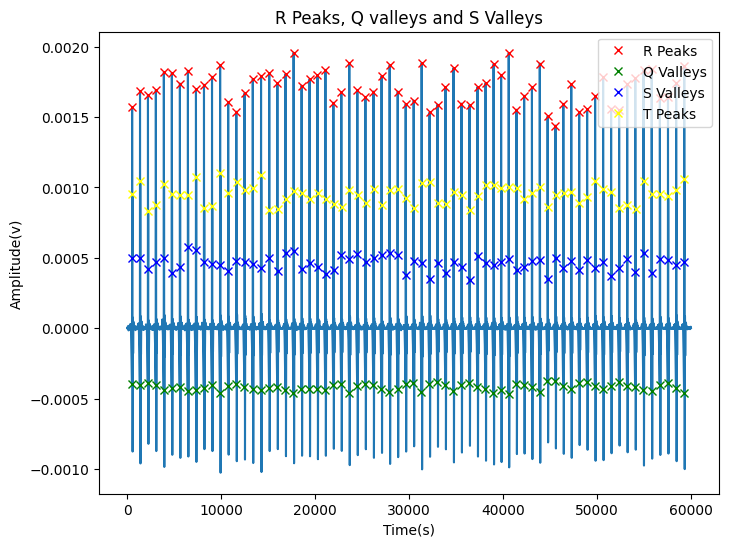

(252, 4)  before
(4, 252)  after
252  y shape
Decision Tree Accuracy = 98.04%
XGBoost Accuracy = 96.08%
SVM Accuracy = 98.04%
Gradient Boosting Accuracy = 98.04%


In [13]:


if __name__ == "__main__":
    folder_path = "data"

    R = []
    S = []
    Q = []
    T = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            r_peak, s_peak, q_peak, t_peak = process_ecg_file(file_path)
            R.append(r_peak)
            S.append(s_peak)
            Q.append(q_peak)
            T.append(t_peak)

    Y = []

    for index, item in enumerate(R):
        l = len(item)
        for m in range(l):
            Y.append(index)

    x1 = [item for sublist in R for item in sublist]
    x2 = [item for sublist in S for item in sublist]
    x3 = [item for sublist in Q for item in sublist]
    x4 = [item for sublist in T for item in sublist]

    X = np.array([x1, x2, x3, x4]).T
    X1 = np.array([x1, x2, x3, x4])

    # print (X.shape, " before")
    # print (X1.shape, " after")
    # print (len(Y), " y shape")


    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Models
    models = {
        'Decision Tree': DecisionTreeClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'SVM': SVC(),
        'Gradient Boosting': GradientBoostingClassifier(),
        # 'Random Forest': RandomForestClassifier()
        # 'Random Forest 1': RandomForestClassifier(n_estimators=50, max_depth=5),
        # 'Random Forest 2': RandomForestClassifier(n_estimators=100, max_depth=10)
    }

    results = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)

        with open(f'{model_name}.pkl', 'wb') as f:
            pickle.dump(model, f)

        predictions = model.predict(X_test)

        accuracy = accuracy_score(y_test, predictions) * 100
        results[model_name] = accuracy

    # Print results
    for model_name, accuracy in results.items():
        print(f'{model_name} Accuracy = {accuracy:.2f}%')
        print('=' * 37)


## Thank you